In [15]:
# 1. Carga de librerías y datos

import pandas as pd
import matplotlib.pyplot as plt

ruta_csv = "../data/backlog_ordenes_trabajo.csv"

df = pd.read_csv(ruta_csv, parse_dates=["fecha_creacion", "fecha_vencimiento"])

df.head()


,id_ot,equipo,fecha_creacion,fecha_vencimiento,criticidad_ot,criticidad_equipo,tipo_trabajo,sistema,estado,dias_backlog,faena,mes
0,BK00001,CAEX-102,2025-07-20,2025-08-17,Media,Baja,Preventivo,Eléctrico,Planificada,11,Faena Atacama Norte,2025-07
1,BK00002,CAEX-104,2025-02-23,2025-03-31,Alta,Media,Mejora,Transmisión,Abierta,158,Faena Atacama Norte,2025-02
2,BK00003,CAEX-101,2025-03-17,2025-04-20,Media,Alta,Mejora,Hidráulico,Planificada,136,Faena Atacama Norte,2025-03
3,BK00004,CAEX-101,2025-02-15,2025-02-22,Alta,Media,Inspección,Neumáticos,Abierta,166,Faena Atacama Norte,2025-02
4,BK00005,CAEX-101,2025-03-13,2025-04-20,Baja,Media,Inspección,Neumáticos,Abierta,140,Faena Atacama Norte,2025-03


In [16]:
# 2. Exploración rápida

print("Filas:", len(df))
print("\nColumnas:", df.columns.tolist())

print("\nTipos de datos:")
print(df.dtypes)

print("\nResumen de dias_backlog:")
print(df["dias_backlog"].describe())

print("\nValores únicos:")
print("Criticidad OT:", df["criticidad_ot"].unique())
print("Criticidad equipo:", df["criticidad_equipo"].unique())
print("Estados:", df["estado"].unique())
print("Meses:", df["mes"].unique())


Filas: 160

Columnas: ['id_ot', 'equipo', 'fecha_creacion', 'fecha_vencimiento', 'criticidad_ot', 'criticidad_equipo', 'tipo_trabajo', 'sistema', 'estado', 'dias_backlog', 'faena', 'mes']

Tipos de datos:
id_ot                        object
equipo                       object
fecha_creacion       datetime64[ns]
fecha_vencimiento    datetime64[ns]
criticidad_ot                object
criticidad_equipo            object
tipo_trabajo                 object
sistema                      object
estado                       object
dias_backlog                  int64
faena                        object
mes                          object
dtype: object

Resumen de dias_backlog:
count    160.000000
mean      88.568750
std       51.946952
min        4.000000
25%       43.500000
50%       80.500000
75%      134.000000
max      180.000000
Name: dias_backlog, dtype: float64

Valores únicos:
Criticidad OT: ['Media' 'Alta' 'Baja']
Criticidad equipo: ['Baja' 'Media' 'Alta']
Estados: ['Planificada' 'Abie

In [17]:
# 3.1 KPIs de backlog

backlog_total = len(df)
backlog_por_criticidad = df["criticidad_ot"].value_counts()
backlog_por_estado = df["estado"].value_counts()

print("Backlog total:", backlog_total)
print("\nBacklog por criticidad:")
print(backlog_por_criticidad)

print("\nBacklog por estado:")
print(backlog_por_estado)


Backlog total: 160

Backlog por criticidad:
criticidad_ot
Alta     60
Baja     56
Media    44
Name: count, dtype: int64

Backlog por estado:
estado
Planificada     54
Abierta         54
En ejecución    52
Name: count, dtype: int64


In [18]:
# 3.2 Edad del backlog

print("Descripción estadística de dias_backlog:")
print(df["dias_backlog"].describe())


Descripción estadística de dias_backlog:
count    160.000000
mean      88.568750
std       51.946952
min        4.000000
25%       43.500000
50%       80.500000
75%      134.000000
max      180.000000
Name: dias_backlog, dtype: float64


In [19]:
# 3.3 Órdenes vencidas respecto de una fecha de corte

fecha_corte = pd.Timestamp("2025-08-01")

df["vencida"] = df["fecha_vencimiento"] < fecha_corte

vencidas = df["vencida"].sum()
pct_vencidas = vencidas / len(df) * 100

print(f"Órdenes vencidas: {vencidas} ({pct_vencidas:.1f}%)")


Órdenes vencidas: 144 (90.0%)


In [20]:
# 4. Modelo de prioridad

# Mapas de criticidad
map_crit = {"Alta": 3, "Media": 2, "Baja": 1}

df["w_criticidad_ot"] = df["criticidad_ot"].map(map_crit)
df["w_criticidad_equipo"] = df["criticidad_equipo"].map(map_crit)

df[["criticidad_ot", "w_criticidad_ot", "criticidad_equipo", "w_criticidad_equipo"]].head()


,criticidad_ot,w_criticidad_ot,criticidad_equipo,w_criticidad_equipo
0,Media,2,Baja,1
1,Alta,3,Media,2
2,Media,2,Alta,3
3,Alta,3,Media,2
4,Baja,1,Media,2


In [21]:
# Normalización de dias_backlog a una escala 0-3

max_dias = df["dias_backlog"].max()
df["w_dias_backlog"] = df["dias_backlog"] / max_dias * 3


In [22]:
map_estado = {
    "Abierta": 3,
    "En ejecución": 2,
    "Planificada": 1
}

df["w_estado"] = df["estado"].map(map_estado)

In [23]:
# Score de prioridad
# Fórmula: 2*criticidad_ot + criticidad_equipo + w_dias_backlog + w_estado

df["score_prioridad"] = (
    2 * df["w_criticidad_ot"]
    + 1 * df["w_criticidad_equipo"]
    + df["w_dias_backlog"]
    + df["w_estado"]
)

# Ver top 10 OT más prioritarias
df_prioridad = df.sort_values("score_prioridad", ascending=False)
df_prioridad[["id_ot", "equipo", "criticidad_ot", "criticidad_equipo",
              "dias_backlog", "estado", "score_prioridad"]].head(10)


,id_ot,equipo,criticidad_ot,criticidad_equipo,dias_backlog,estado,score_prioridad
45,BK00046,CAEX-102,Alta,Alta,158,Abierta,14.633333
115,BK00116,CAEX-103,Alta,Alta,179,En ejecución,13.983333
13,BK00014,CAEX-107,Alta,Alta,112,Abierta,13.866667
3,BK00004,CAEX-101,Alta,Media,166,Abierta,13.766667
14,BK00015,CAEX-107,Alta,Alta,102,Abierta,13.700000
1,BK00002,CAEX-104,Alta,Media,158,Abierta,13.633333
20,BK00021,CAEX-107,Alta,Alta,144,En ejecución,13.400000
80,BK00081,CAEX-102,Alta,Media,144,Abierta,13.400000
101,BK00102,CAEX-107,Alta,Alta,83,Abierta,13.383333
88,BK00089,CAEX-107,Alta,Alta,73,Abierta,13.216667


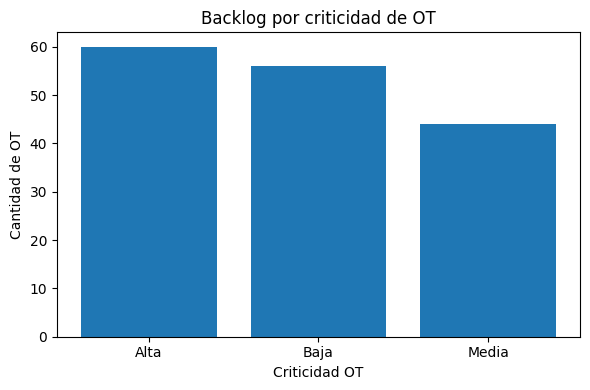

In [24]:
# 5.1 Backlog por criticidad

backlog_por_criticidad = df["criticidad_ot"].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(backlog_por_criticidad.index, backlog_por_criticidad.values)
plt.xlabel("Criticidad OT")
plt.ylabel("Cantidad de OT")
plt.title("Backlog por criticidad de OT")
plt.tight_layout()

plt.savefig("../img/backlog_por_criticidad.png", dpi=150)
plt.show()


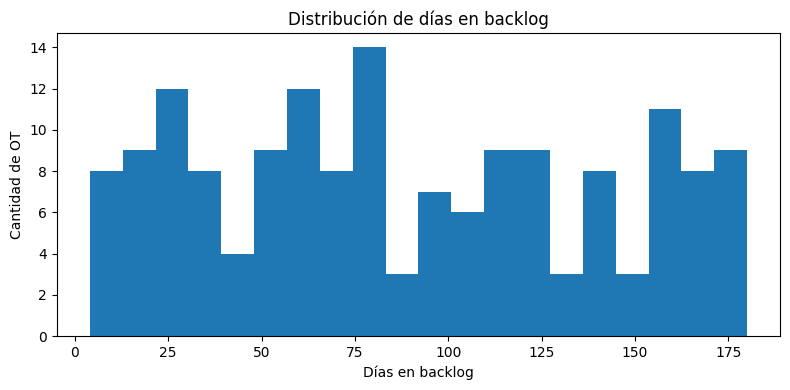

In [25]:
# 5.2 Distribución de días en backlog

plt.figure(figsize=(8, 4))
plt.hist(df["dias_backlog"], bins=20)
plt.xlabel("Días en backlog")
plt.ylabel("Cantidad de OT")
plt.title("Distribución de días en backlog")
plt.tight_layout()

plt.savefig("../img/distribucion_dias_backlog.png", dpi=150)
plt.show()


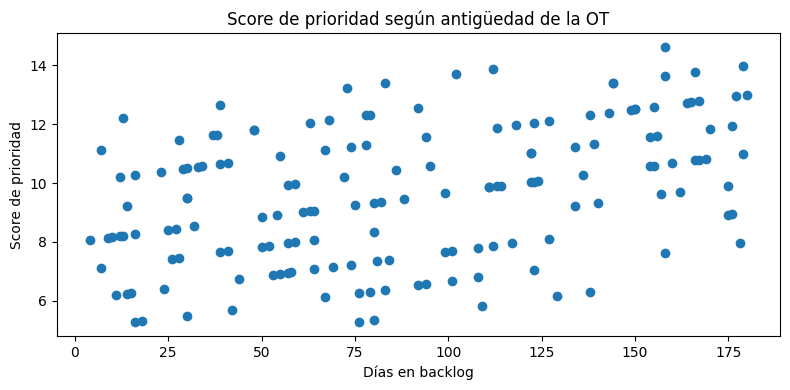

In [26]:
# 5.3 Relación entre dias_backlog y score de prioridad

plt.figure(figsize=(8, 4))
plt.scatter(df["dias_backlog"], df["score_prioridad"])
plt.xlabel("Días en backlog")
plt.ylabel("Score de prioridad")
plt.title("Score de prioridad según antigüedad de la OT")
plt.tight_layout()

plt.savefig("../img/score_vs_dias_backlog.png", dpi=150)
plt.show()
